In [1]:
# Import Keras and other Deep Learning dependencies
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model, load_model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense, Dropout
from keras.initializers import glorot_uniform
from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import *
from keras.engine.topology import Layer
from keras.regularizers import l2
import cv2
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
from tqdm import tqdm_notebook
from sklearn.metrics import accuracy_score
from sklearn import metrics
from collections import Counter 
from IPython.display import clear_output
import pandas as pd
from matplotlib import gridspec
from keras.optimizers import RMSprop
from keras import activations

Using TensorFlow backend.


In [2]:
def initialize_weights(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

def get_siamese_model(input_shape, similarity_metric='l1', verbose=True):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    left_input = Input(input_shape)
    right_input = Input(input_shape)
#     model = Sequential()
#     model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape,
#                     kernel_initializer=initialize_weights, 
#                     kernel_regularizer=l2(2e-4)))
    
#     model.add(Conv2D(64, (3,3), activation='relu', input_shape=input_shape,
#                     kernel_initializer=initialize_weights, 
#                     kernel_regularizer=l2(2e-4)))    
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    
#     model.add(Dropout(0.25))
#     model.add(Flatten())
    
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.25))
    
#     model.add(Dense(input_shape[0]**2, activation='sigmoid', kernel_initializer=initialize_weights,
#                     bias_initializer=initialize_bias, 
#                     kernel_regularizer=l2(1e-3),))
    
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.1))
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.1))
#     model.add(Dense(128, activation='relu'))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    if similarity_metric == 'l1':
        Similarity_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))        
        Similarity_distance = Similarity_layer([encoded_l, encoded_r])
    elif similarity_metric == 'l2':
        Similarity_layer = Lambda(euclidean_distance)
        Similarity_distance = Similarity_layer([encoded_l, encoded_r])
           
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(Similarity_distance)
    
    # Connect the input with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    if verbose:
        model.summary()
    return siamese_net

def get_normalized_X_corr_model(input_shape):
    a = Input(input_shape)
    b = Input(input_shape)
    model = Sequential()
    model.add(Conv2D(kernel_size = (5,5), filters = 20,input_shape = input_shape, activation = 'relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(kernel_size = (5,5), filters =  25, activation = 'relu'))
    model.add(MaxPooling2D((2,2)))
    model1 = model(b)
    model2 = model(a)
    normalized_layer = Normalized_Correlation_Layer(stride = (1,1), patch_size = (5, 5))([model1, model2])
    final_layer = Conv2D(kernel_size=(1,1), filters=25, activation='relu')(normalized_layer)
    final_layer = Conv2D(kernel_size=(3,3), filters=25, activation = None)(final_layer)
    final_layer = MaxPooling2D((2,2))(final_layer)
    final_layer = Dense(500)(final_layer)
    final_layer = Dense(1, activation = "softmax")(final_layer)
    x_corr_mod = Model(inputs=[a,b], outputs = final_layer)
    try:
        x_corr_mod.summary()
    except:
        pass
    print(x_corr_mod.output._keras_shape)
    return x_corr_mod

In [3]:
class Normalized_Correlation_Layer(Layer):
    '''
    This layer does Normalized Correlation.
    
    It needs to take two inputs(layers),
    currently, it only supports the border_mode = 'valid',
    if you need to output the same shape as input, 
    do padding before giving the layer.
    
    '''
    def __init__(self, patch_size=(5,5),
                 dim_ordering='tf',
                 border_mode='same',
                 stride=(1, 1),
                 activation=None,
                 **kwargs):

        if border_mode != 'same':
            raise ValueError('Invalid border mode for Correlation Layer '
                             '(only "same" is supported as of now):', border_mode)
        self.kernel_size = patch_size
        self.subsample = stride
        self.dim_ordering = dim_ordering
        self.border_mode = border_mode
        self.activation = activations.get(activation)
        super(Normalized_Correlation_Layer, self).__init__(**kwargs)


    def compute_output_shape(self, input_shape):
        if self.dim_ordering == 'tf':
            inp_rows = input_shape[0][1]
            inp_cols = input_shape[0][2]
        else:
            raise ValueError('Only support tensorflow.')
        
        if self.border_mode != "same":
            rows = conv_output_length(inp_rows, self.kernel_size[0],
                                       self.border_mode, 1)
            cols = conv_output_length(inp_cols, self.kernel_size[1],
                                       self.border_mode, 1)
        else:
            rows = inp_rows
            cols = inp_cols
        
        return (input_shape[0][0], rows, cols,self.kernel_size[0]*cols*input_shape[0][-1])
    

    def call(self, x, mask=None):
        input_1, input_2 = x
        stride_row, stride_col = self.subsample
        inp_shape = input_1._keras_shape
        output_shape = self.compute_output_shape([inp_shape, inp_shape])
        
        padding_row = (int(self.kernel_size[0] / 2),int(self.kernel_size[0]))
        padding_col = (int(self.kernel_size[1] / 2),int(self.kernel_size[1]))
        input_1 = K.spatial_2d_padding(input_1, padding =(padding_row,padding_col))
        input_2 = K.spatial_2d_padding(input_2, padding = ((padding_row[0]*2, padding_row[1]*2),padding_col))
        
        #print(input_1.shape)
        output_row = output_shape[1]
        output_col = output_shape[2]

        output = []
        for k in range(inp_shape[-1]):
            xc_1 = []
            xc_2 = []
            for i in range(padding_row[0]):
                for j in range(output_col):
                    xc_2.append(K.reshape(input_2[:, i:i+self.kernel_size[0], j:j+self.kernel_size[1], k],
                                          (-1, 1,self.kernel_size[0]*self.kernel_size[1])))
            for i in range(output_row):
                slice_row = slice(i, i + self.kernel_size[0])
                slice_row2 = slice(i+padding_row[0], i +self.kernel_size[0]+padding_row[0])
                for j in range(output_col):
                    slice_col = slice(j, j + self.kernel_size[1])
                    xc_2.append(K.reshape(input_2[:, slice_row2, slice_col, k],
                                          (-1, 1,self.kernel_size[0]*self.kernel_size[1])))
                    if i % stride_row == 0 and j % stride_col == 0:
                        xc_1.append(K.reshape(input_1[:, slice_row, slice_col, k],
                                              (-1, 1,self.kernel_size[0]*self.kernel_size[1])))
            for i in range(output_row, output_row+padding_row[0]):
                for j in range(output_col):
                    xc_2.append(K.reshape(input_2[:, i:i+ self.kernel_size[0], j:j+self.kernel_size[1], k],
                                          (-1, 1,self.kernel_size[0]*self.kernel_size[1])))

            xc_1_aggregate = K.concatenate(xc_1, axis=1) # batch_size x w'h' x (k**2*d), w': w/subsample-1
            xc_1_mean = K.mean(xc_1_aggregate, axis=-1, keepdims=True)
            xc_1_std = K.std(xc_1_aggregate, axis=-1, keepdims=True)
            xc_1_aggregate = (xc_1_aggregate - xc_1_mean) / xc_1_std
    
            xc_2_aggregate = K.concatenate(xc_2, axis=1) # batch_size x wh x (k**2*d), w: output_row
            xc_2_mean = K.mean(xc_2_aggregate, axis=-1, keepdims=True)
            xc_2_std = K.std(xc_2_aggregate, axis=-1, keepdims=True)
            xc_2_aggregate = (xc_2_aggregate - xc_2_mean) / xc_2_std
            xc_1_aggregate = K.permute_dimensions(xc_1_aggregate, (0, 2, 1))
            block = []
            len_xc_1= len(xc_1)
            for i in range(len_xc_1):
                sl1 = slice(int(i/inp_shape[1])*inp_shape[1],
                        int(i/inp_shape[1])*inp_shape[1]+inp_shape[1]*self.kernel_size[0])
                block.append(K.reshape(K.batch_dot(xc_2_aggregate[:,sl1,:],
                                      xc_1_aggregate[:,:,i]),(-1,1,1,inp_shape[1]*self.kernel_size[0])))

            block = K.concatenate(block, axis=1)
            block = K.reshape(block,(-1,output_row,output_col,inp_shape[1]*self.kernel_size[0]))
            output.append(block)
        output = K.concatenate(output, axis=-1)
        output = self.activation(output)
        print(output.shape)
        return output

    def get_config(self):
        config = {'patch_size': self.kernel_size,
                  'activation': self.activation.__name__,
                  'border_mode': self.border_mode,
                  'stride': self.subsample,
                  'dim_ordering': self.dim_ordering}
        base_config = super(Correlation_Layer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [4]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [5]:
class Siamese_Loader:
    def __init__(self, train_path=None, 
                 test_path=None, dataset_type = '49kmnist',
                 images=None, labels=None, img_channel=1):
        """
        Loads dataset
        
        Parameters
        -----------
        
        train_path ... list[train_images, train_labels]
        test_path ... list[test_images, test_labels]
        
        """
        self.train_images = []
        self.train_labels = []
        self.train_path = train_path
        
        self.test_images = []
        self.test_labels = []        
        self.test_path = test_path
        
        self.dataset_type = dataset_type        
        
        if train_path is None and test_path is None:
            self.train_images = images[0]
            self.train_labels = labels[0]
            self.test_images = images[1]
            self.test_labels = labels[1] 
        
        else:        
            print('Loading Train images')
            self.train_images = self._load(self.train_path[0])

            print('Loading Test images')
            self.test_images = self._load(self.test_path[0])

            print('Loading Train labels')
            self.train_labels = self._load(self.train_path[1])

            print('Loading Test labels')
            self.test_labels = self._load(self.test_path[1])

        self.train_n_classes = len(np.unique(self.train_labels))
        self.test_n_classes = len(np.unique(self.test_labels))
        
        self.train_shape = self.train_images[0].shape
        self.test_shape = self.test_images[0].shape
        
        self.image_channel = img_channel
        
    def _load(self, f):
        return np.load(f)['arr_0']
        
    def _get_index(self, labels, i, images):
        while True:
            idx = np.random.randint(0, len(images))
            if labels[idx] == i:
                return idx, labels[idx]
            
    def _get_false_index(self, labels, i, images):
        while True:
            idx = np.random.randint(0, len(images))
            if labels[idx] != i:
                return idx, labels[idx]
            
    def get_batch(self, batch_multiplier = 1, disable_progress_bar = False):
        
        if type(batch_multiplier) is float:
            raise TypeError('batch_multiplier must be an integer')
        
        n_examples = batch_multiplier*self.train_n_classes*2
        
        img_shape = self.train_images[0].shape
        pairs = [np.zeros((n_examples, img_shape[0], img_shape[1], self.image_channel)) for i in range(2)]
        categs_list = []
        targets = []
        
        images = self.train_images
        labels = self.train_labels
        n_classes = self.train_n_classes
        
        k = 0
        for i in tqdm_notebook(range(0, batch_multiplier), disable = disable_progress_bar):
            img_1 = None
            img_2 = None
            
            for j in range(0, n_classes):
                idx_1, categ_1 = self._get_index(labels, j, images)
                img_1 = self.train_images[idx_1]
                idx_2, categ_2 = self._get_index(labels, j, images)
                img_2 = images[idx_2]
                categs_list.append([categ_1,categ_2])
                target = 1
                
                pairs[0][k] = img_1.reshape((self.train_shape[0], self.train_shape[1], self.image_channel))
                pairs[1][k] = img_2.reshape((self.train_shape[0], self.train_shape[1], self.image_channel))
                targets.append(target)
                k += 1
            
            for j_ in range(0, n_classes):
                idx_1, categ_1 = self._get_index(labels, j_, images)
                img_1 = self.train_images[idx_1]
                idx_2, categ_2 = self._get_false_index(labels, j_, images)
                img_2 = images[idx_2]
                categs_list.append([categ_1,categ_2])
                target = 0
                
                pairs[0][k] = img_1.reshape((self.train_shape[0], self.train_shape[1], self.image_channel))
                pairs[1][k] = img_2.reshape((self.train_shape[0], self.train_shape[1], self.image_channel))
                targets.append(target)
                k += 1

            
        pairs[0] /= 255.
        pairs[1] /= 255.
        
        return pairs, targets, categs_list
    
    def get_data(self, size=2, total_sample_size=10000):
        #read the image
    #     image = read_image('data/orl_faces/s' + str(1) + '/' + str(1) + '.pgm', 'rw+')
    #     #reduce the size
    #     image = image[::size, ::size]
        #get the new size
        img_shape = self.train_images[0].shape
        dim1 = img_shape[0]
        dim2 = img_shape[1]

        images = self.train_images
        labels = self.train_labels
        n_classes = self.train_n_classes

        count = 0

        #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
        x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2]) # 2 is for pairs
        y_genuine = np.zeros([total_sample_size, 1])

        for i in tqdm_notebook(range(n_classes)):
            for j in range(int(total_sample_size/n_classes)):
                ind1 = 0
                ind2 = 0

                #read images from same directory (genuine pair)
                classe = np.random.randint(n_classes)

                ind1, _ = self._get_index(labels, classe, images)
                ind2, _ = self._get_index(labels, classe, images)

                # read the two images
                img1 = images[ind1]
                img2 = images[ind2]

                #store the images to the initialized numpy array
                x_geuine_pair[count, 0, 0, :, :] = img1
                x_geuine_pair[count, 1, 0, :, :] = img2

                #as we are drawing images from the same directory we assign label as 1. (genuine pair)
                y_genuine[count] = 1
                count += 1

        count = 0
        x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
        y_imposite = np.zeros([total_sample_size, 1])

        for i in tqdm_notebook(range(int(total_sample_size/n_classes))):
            for j in range(n_classes):

                #read images from different directory (imposite pair)
                classe = np.random.randint(n_classes)

                ind1, _ = self._get_false_index(labels, classe, images)
                ind2, _ = self._get_index(labels, classe, images)

                # read the two images
                img1 = images[ind1]
                img2 = images[ind2]

                x_imposite_pair[count, 0, 0, :, :] = img1
                x_imposite_pair[count, 1, 0, :, :] = img2
                #as we are drawing images from the different directory we assign label as 0. (imposite pair)
                y_imposite[count] = 0
                count += 1
        print(len(x_geuine_pair))
        print(len(x_imposite_pair))
        #now, concatenate, genuine pairs and imposite pair to get the whole data
        X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
        Y = np.concatenate([y_genuine, y_imposite], axis=0)

        return X, Y    
        
    def one_shot_task(self, N = 49, tipo = 'train'):
        """
        Create a set of pairs, targets for N-way one shot learning.
        """
        if tipo == 'train':
            images = self.train_images
            labels = self.train_labels
            n_classes = self.train_n_classes
        else:
            images = self.test_images
            labels = self.test_labels
            n_classes = self.test_n_classes
            
        
        img_shape = images[0].shape
        pairs = [np.zeros((N, img_shape[0], img_shape[1], self.image_channel)) for i in range(2)]
        targets = []
        idxs_pairs = []
        k = 0
        
        i_sorteado = np.random.randint(0,n_classes)
        
        idx_base, categ_base = self._get_index(labels, i_sorteado, images)
        img_base = images[idx_base]
        

        idx_pair, categ_pair = self._get_index(labels, i_sorteado, images)
        img_pair = images[idx_pair]
        idxs_pairs.append(idx_pair)
        
        pairs[0][k] = img_base.reshape((self.train_shape[0], self.train_shape[1], self.image_channel))
        pairs[1][k] = img_pair.reshape((self.train_shape[0], self.train_shape[1], self.image_channel))
        targets.append(1)
        
        for j in range(1, N):
            
            idx_pair, categ_pair = self._get_false_index(labels, i_sorteado, images)
            img_pair = images[idx_pair]
            idxs_pairs.append(idx_pair)


            if categ_base == categ_pair:
                targets.append(1)
            else:
                targets.append(0)
            
            k += 1
            pairs[0][k] = img_base.reshape((self.train_shape[0],self.train_shape[1],self.image_channel))
            pairs[1][k] = img_pair.reshape((self.train_shape[0],self.train_shape[1],self.image_channel))

            
        
        pairs[0] /= 255.
        pairs[1] /= 255.
        
        return pairs, targets, idxs_pairs
    
    def one_shot_retrieval(self, query_image, top_n=10):
        
        images = self.test_images
        labels = self.test_labels
        n_classes = self.test_n_classes
        shape = self.test_shape
        
        img_shape = images[0].shape
        pairs = [np.zeros((n_classes, img_shape[0], img_shape[1], self.image_channel)) for i in range(2)]
        idxs_pairs = []
        
        img_base = query_image
        
        for j in range(0, n_classes):
            
            idx_pair, categ_pair = self._get_index(labels, j, images)
            img_pair = images[idx_pair]
            idxs_pairs.append(idx_pair)
            
            pairs[0][j] = img_base.reshape((shape[0], shape[1], self.image_channel))
            pairs[1][j] = img_pair.reshape((shape[0], shape[1], self.image_channel))            
        
        pairs[0] /= 255.
        pairs[1] /= 255.
        
        return pairs, idxs_pairs
    
    def test_oneshot(self, model, N, k, verbose=True, tipo = 'test'):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
        for i in range(k):
            inputs, targets = self.one_shot_task(N, tipo = tipo)
            probs = model.predict(inputs)
            probs = 1-probs
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
        return percent_correct
    
    def image_retrieval(self, model, img_search, top_n=5):
        images = self.test_images
        labels = self.test_labels
        n_imgs = len(images)
        
        img_shape = images[0].shape
        pairs = [np.zeros((n_imgs, img_shape[0], img_shape[1], self.image_channel)) for i in range(2)]
        targets = []
        idx_imgs = []
        k = 0
        
        img_base = img_search
        
        for i in range(0, n_imgs):            
            img_pair = images[i]
            pairs[0][k] = img_base.reshape((img_shape[0], img_shape[1], self.image_channel))
            pairs[1][k] = img_pair.reshape((img_shape[0], img_shape[1], self.image_channel))
            idx_imgs.append(i)
            k += 1
        
        pairs[0] /= 255.
        pairs[1] /= 255.
        
        predict = model.predict(pairs)
        df = pd.DataFrame(data={'indice':idx_imgs, 'predict':predict.reshape((len(predict)))})
        df_N = df.sort_values(by=['predict'])[0:top_n]
        ranking_list = df_N['indice'].tolist()
        
        self.plot_rank(idxs=np.array(ranking_list))
        return ranking_list, df
    
    def plot_rank(self, idxs):
        if type(idxs) != np.ndarray:
            idxs = np.array([idxs])
        fig = plt.figure()
        gs = gridspec.GridSpec(1,len(idxs))
        for i in range(len(idxs)):
            ax = fig.add_subplot(gs[0,i])
            ax.imshow(self.test_images[idxs[i]], cmap='gray')
            ax.axis('off')
        plt.show()

In [6]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

def plot_oneshot_task(ref, comparativas, x_s = 28, y_s = 28):
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(ref.reshape(x_s,y_s), cmap='gray')
    img = concat_images(comparativas)
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
def show_image(img):
    plt.imshow(img, cmap="gray")
    plt.show()

In [6]:
# batch_size = 128
# num_classes = 10
# epochs = 12

In [7]:
# def load(f):
#     return np.load(f)['arr_0']

In [8]:
# Load the data
# x_train = load('dataset/kuzushiji-mnist/k49-train-imgs.npz')
# x_test = load('dataset/kuzushiji-mnist/k49-test-imgs.npz')
# y_train = load('dataset/kuzushiji-mnist/k49-train-labels.npz')
# y_test = load('dataset/kuzushiji-mnist/k49-test-labels.npz')

In [9]:
# ys = list()
# for y in y_train:
#     if y not in ys:
#         ys.append(y)
# print('N classes: {}'.format(len(ys)))
# print(len(Counter(y_train).keys()))
# np.unique(y_train, return_counts=True)

# Kuzushiji 49

### Model

In [103]:
# model = get_siamese_model((28, 28, 1), verbose=True)
# model.compile(loss=contrastive_loss,optimizer=Adam(lr = 0.00006))
# # model.compile(loss=contrastive_loss,optimizer=Adadelta())
# # model.compile(loss='binary_crossentropy',optimizer=Adam(lr = 0.00006))
# model.summary()

### Loading dataset

In [108]:
# loader = Siamese_Loader(train_path=['dataset/kuzushiji-mnist/k49-train-imgs.npz',
#                                     'dataset/kuzushiji-mnist/k49-train-labels.npz'],
#                        test_path=['dataset/kuzushiji-mnist/k49-test-imgs.npz',
#                                   'dataset/kuzushiji-mnist/k49-test-labels.npz'])

In [109]:
# train_pairs, train_targets = loader.get_batch(batch_multiplier=2)

In [110]:
# N = 10
# test_pairs, test_targets = loader.one_shot_task(N=N, tipo='test')
# print(test_targets)

# plot_oneshot_task(test_pairs[0][9], test_pairs[1][:N])

### Training pipeline 1

In [111]:
# evaluate = 100 # interval for evaluating on one-shot tasks and losses
# batch_multiplier = 5
# n_iter = 2000 # 20000
# best = -1
# N_way = 10
# data_path = 'kmodel_weights/'
# weights_path_2 = 'kmodel_weights/kmodel_weights_1.h5'

In [112]:
# print("Starting training process!")
# print("##############################################################")
# t_start = time.time()
# for i in tqdm_notebook(range(1, n_iter)):
    
#     inputs, targets = loader.get_batch(batch_multiplier, disable_progress_bar=True)
    
#     loss=model.train_on_batch(inputs,targets)
    
#     if i % evaluate == 0:
#         clear_output()
#         print("Time for {0} iterations: {1}".format(i, time.time()-t_start))
#         val_acc = loader.test_oneshot(model,N_way,20,verbose=True)
#         if val_acc >= best:
#             print("Current best: {0}, previous best: {1}".format(val_acc, best))
#             print("Saving weights to: {0} \n".format(weights_path_2))
#             model.save_weights(weights_path_2)
#             best=val_acc   
    
#         print("iteration {}, training loss: {:.2f},".format(i,loss))
#         print('---------------------------------------------------------------------------------')

        
# # weights_path_2 = os.path.join(data_path, "model_weights.h5")
# # model.load_weights(weights_path_2)

### Training pipeline 2

In [113]:
# model.fit(x=train_pairs, y=train_targets, epochs=2000) 

In [114]:
# weight_path_fit = 'kmodel_weights/model_weights_2_10.h5'
# model.save_weights(weight_path_fit)

In [115]:
# len(test_pairs[0])

In [116]:
# N = 10
# test_pairs, test_targets = loader.one_shot_task(N=N, tipo='test')
# plot_oneshot_task(test_pairs[0][9], test_pairs[1][:N])

In [117]:
# predict = model.predict(x=test_pairs)
# predict

In [118]:
# fpr, tpr, thresholds = metrics.roc_curve(test_targets, predict)
# metrics.auc(fpr, tpr)

# OMNIGLOT - ひらがな

In [14]:
#!pip install scipy==1.1.0

In [7]:
from load_data import *

loading alphabet: Japanese_(hiragana)
loading alphabet: Japanese_(hiragana)


In [8]:
data_path = os.path.join('dataset/omniglot')
train_folder = os.path.join(data_path,'images_train')
valpath = os.path.join(data_path,'images_test')

In [9]:
with open(os.path.join(data_path, "pickle/train.pickle"), "rb") as f:
    (X, classes) = pickle.load(f)

with open(os.path.join(data_path, "pickle/val.pickle"), "rb") as f:
    (Xval, val_classes) = pickle.load(f)
    
print("Training alphabets: \n")
print(list(classes.keys()))
print("Validation alphabets:", end="\n\n")
print(list(val_classes.keys()))

Training alphabets: 

['Japanese_(hiragana)']
Validation alphabets:

['Japanese_(hiragana)']


In [10]:
x_train = []
y_train = []
x_test = []
y_test = []

target = 0
for classe in X:    
    for img in classe:
        x_train.append(255 - img)
        y_train.append(target)
    target += 1

target = 0
for classe in Xval:    
    for img in classe:
        x_test.append(255 - img)
        y_test.append(target)
    target += 1    

In [11]:
x_imgs = np.asarray([np.asarray(x_train), np.asarray(x_test)])
y_lbls = np.asarray([np.asarray(y_train), np.asarray(y_test)])

In [12]:
x_imgs[0].shape

(780, 105, 105)

### Omni Loader

In [13]:
omni_loader = Siamese_Loader(images = x_imgs, labels=y_lbls, dataset_type='omniglot_hiragana')

In [14]:
omni_loader.dataset_type

'omniglot_hiragana'

### Model

In [15]:
model_hiragana = get_siamese_model((105, 105, 1), verbose=False, similarity_metric='l1')
model_hiragana.compile(loss=contrastive_loss,optimizer=Adam(lr = 0.00006),metrics=[accuracy])
# model_hiragana.compile(loss=contrastive_loss,optimizer=RMSprop(),metrics=[accuracy])
# model.compile(loss=contrastive_loss,optimizer=Adadelta())
# model.compile(loss='binary_crossentropy',optimizer=Adam(lr = 0.00006))
model_hiragana.summary()

W1030 21:57:31.439613 16664 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1030 21:57:31.587575 16664 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1030 21:57:31.639565 16664 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1030 21:57:38.868435 16664 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1030 21:57:38.948413 16664 deprecation_wrapper.py:119] From C:\ProgramData\Ana

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         38947648    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[1][0]               
          

### Few-shot testing

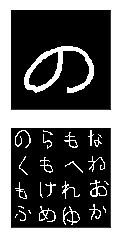

In [16]:
N = 16
test_pairs, test_targets, idxs_pairs = omni_loader.one_shot_task(N=N, tipo='test')

plot_oneshot_task(test_pairs[0][9], test_pairs[1][:N], x_s=105, y_s=105)

In [17]:
idxs_pairs

[120, 194, 172, 104, 38, 172, 144, 116, 174, 245, 205, 20, 137, 165, 180, 244]

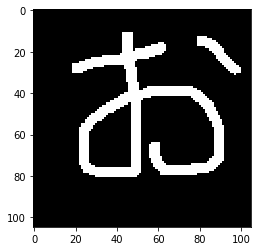

In [18]:
show_image(omni_loader.test_images[20].reshape((105,105)))

### Training

In [19]:
evaluate = 100 # interval for evaluating on one-shot tasks and losses
batch_multiplier = 10
n_iter = 600 # 20000
best = -1
N_way = 10
data_path = 'kmodel_weights/'
weights_path_2 = 'kmodel_weights/1000_inv_omni_model_hiragana_weights_1.h5'

In [20]:
# print("Starting training process!")
# print("##############################################################")
# t_start = time.time()
# for i in tqdm_notebook(range(1, n_iter)):
    
#     inputs, targets, _ = omni_loader.get_batch(batch_multiplier, disable_progress_bar=True)
    
#     loss=model_hiragana.train_on_batch(inputs,targets)
    
#     if i % evaluate == 0:
#         clear_output()
#         print("Time for {0} iterations: {1}".format(i, time.time()-t_start))
#         val_acc = omni_loader.test_oneshot(model_hiragana,N_way,1,verbose=True)
#         if val_acc >= best:
#             print("Current best: {0}, previous best: {1}".format(val_acc, best))
#             print("Saving weights to: {0} \n".format(weights_path_2))
#             model_hiragana.save_weights(weights_path_2)
#             best=val_acc   
    
#         print("iteration {}, training loss: {:.2f},".format(i,loss))
#         print('---------------------------------------------------------------------------------')

In [21]:
# tr_x, tr_y, _ = omni_loader.get_batch(batch_multiplier=10)
# model_hiragana.fit([ tr_x[0], tr_x[1] ], tr_y,
#                    batch_size=32,
#                    epochs=20)
# model_hiragana.save_weights(weights_path_2)

### Testing stuff

In [22]:
inputs, targets, categs_list = omni_loader.get_batch(batch_multiplier, disable_progress_bar=True)
# inputs, targets = loader.get_batch(batch_multiplier, disable_progress_bar=True)

In [23]:
len(inputs[0])

1040

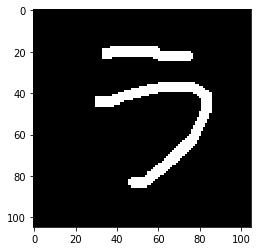

In [24]:
plt.imshow(inputs[0][2].reshape((105,105)), cmap='gray')

plt.show()

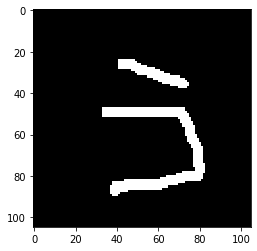

In [25]:
plt.imshow(inputs[1][2].reshape((105,105)), cmap='gray')

plt.show()

In [26]:
print(targets)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

#### One shot task

In [74]:
x_t, y_t, ids_ = omni_loader.one_shot_task(N=10, tipo='test')

In [75]:
print(y_t)

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


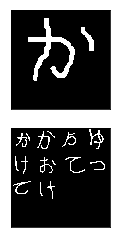

In [76]:
plot_oneshot_task(x_t[0][0], x_t[1], x_s=105, y_s=105)

In [52]:
model_hiragana.load_weights('kmodel_weights/gc/1000iter_inv_omni_model_hiragana_weights.h5')

In [53]:
correct = 0
n = 10
retrieval = []
retrieval_probs = []
for i in tqdm_notebook(range(1, n+1)):
    x_t, y_t, indices = omni_loader.one_shot_task(N=50, tipo='test')
    predict = model_hiragana.predict([ x_t[0], x_t[1] ])
    if np.argmin(predict) == 0:
        correct += 1
        retrieval.append(indices[0])
        retrieval_probs.append(predict[0])
    print('Precisao: {}%'.format((correct/i)*100))  

Precisao: 0.0%
Precisao: 0.0%
Precisao: 33.33333333333333%
Precisao: 50.0%
Precisao: 60.0%
Precisao: 50.0%
Precisao: 42.857142857142854%
Precisao: 50.0%
Precisao: 55.55555555555556%
Precisao: 50.0%



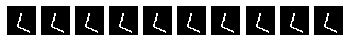

In [79]:
n = 100
query_img = x_t[0][0] 
retrieval = []
retrieval_probs = []
for i in tqdm_notebook(range(1, n+1)):
    x_t, indices = omni_loader.one_shot_retrieval(query_img)
    predict = model_hiragana.predict([ x_t[0], x_t[1] ])
    
    retrieval.append(indices[np.argmin(predict)])
    retrieval_probs.append(predict[np.argmin(predict)])


df = pd.DataFrame(data={'indice':retrieval, 'predict':retrieval_probs})
df_N = df.sort_values(by=['predict'])
ranking_list = df_N['indice'].tolist()
    
    
omni_loader.plot_rank(np.asarray(ranking_list[0:10]))

In [51]:
np.argmin(model_hiragana.predict([ x_t[0], x_t[1] ]))

11

In [49]:
indices[11]

58

In [50]:
retrieval

[38, 36, 39, 37, 88, 38, 39, 38, 38, 58]

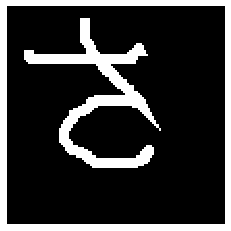

In [46]:
omni_loader.plot_rank(np.asarray(indices[10:11]))

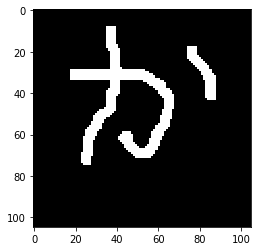

In [77]:
show_image(x_t[0][0].reshape((105,105)))

# Brainstorm

### hide

In [36]:
#predict = model_hiragana.predict(x_t)
#np.argmin(predict)

# print(predict)

# df = pd.DataFrame(data={'indice':ids_, 
#                         'predict':predict.reshape((len(predict)))})

# df.sort_values(by=['predict'])[0:5]

# b = df.sort_values(by=['predict'])[0:5]

# omni_loader.plot_rank(np.array(b['indice'].tolist()))

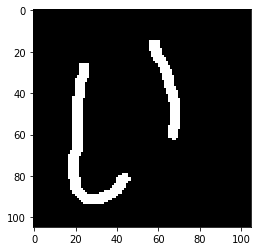

In [35]:
show_image(x_t[0][0].reshape((105,105)))

In [78]:
rank, p = omni_loader.image_retrieval(model=model_hiragana, img_search=x_t[1][10], top_n=20)

In [77]:
p.head(n=10)

,indice,predict
0,0,1.000000
1,1,1.000000
2,2,1.000000
3,3,1.000000
4,4,1.000000
5,5,0.789935
6,6,0.868528
7,7,0.914170
8,8,0.591997
9,9,0.984838


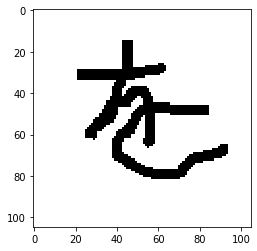

In [39]:
show_image(omni_loader.test_images[226].reshape((105,105)))

In [69]:
np.random.choice(range(3), size=3,replace=False)

array([2, 0, 1])

In [72]:
a = [None]
print(1 not in a)

True


In [128]:
teste, t, _ = omni_loader.get_batch(200)

In [129]:
len(t)

20800

In [9]:
xcor_model = get_normalized_X_corr_model((105,105,1))

(?, 23, 23, 2875)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 23, 23, 25)   13045       input_4[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
normalized__correlation__layer_ (None, 23, 23, 2875) 0           sequential_2[1][0]        

In [49]:
x, y = omni_loader.get_data()


10000
10000


TypeError: cannot unpack non-iterable NoneType object